## Trajectory Optimization of a Bouncing Ball

Explore how contact forces and discontinous dynamics can be handled in optimization. 

Inelastic collision of ball on ground, similar to that of the skateboard wheels hitting the ground.

In [339]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# create symbolic variables
# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{ball}') # mass
hb = sym.symbols('h_{ball}') # height

# generalized coordinates
y = sym.symbols('y') 
dy = sym.symbols('\dot{y}') 
ddy = sym.symbols('\ddot{y}') 

# forces
GRF = sym.symbols('GRF_{impact}') # impulsive impact force

EOMy = mb*ddy + mb*g - GRF
EOMy = EOMy.simplify()
    
EOMs = sym.Matrix([EOMy])
    
display(sym.solve(EOMs,ddy))

In [340]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,
            y,dy,ddy,
            GRF]
            
lambEOMy = sym.lambdify(sym_list,EOMy,modules = [func_map])

In [341]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 30
m.N = RangeSet(N)


DOFs = ['x','y'] # generalized coordinates
m.DOF = Set(initialize = DOFs)

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 1.0) # mass of board

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# ground reaction force
m.GRF = Var(m.N, m.DOF, bounds = (0.0,None))

# bound variables
for n in range(1,N+1):
    m.q[n,'y'].setlb(0.0)

# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof] #semi-backward Euler
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# Ground function --------------------------------------------------------------------------------------------------------------
Y_step = 0.4
X_step = 0.0

signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

m.Gfunc = Var(m.N, m.DOF, bounds = (0.0,Y_step)) # ground function
m.q_sgn = Var(m.N, m.DOF, m.sgn, bounds = (0.0, None)) # position of ball - slack

def def_pball_sgn_g(m,n):
    return m.q_sgn[n,'x','ps'] - m.q_sgn[n,'x','ng'] == m.q[n,'x'] - X_step
m.def_pball_sgn_g = Constraint(m.N, rule = def_pball_sgn_g)

# penalty for handling the changing ground function
ground_func_constraints = ['ground1','ground2']
m.ground_func_constraints = Set(initialize = ground_func_constraints) # set for indexing ground-related penalties
m.ground_func_penalty = Var(m.N, m.ground_func_constraints, bounds = (0.0,None))

def def_Gfunc(m,n,gc):
    if gc == 'ground1':
        return m.ground_func_penalty[n,'ground1'] == m.Gfunc[n,'y']*m.q_sgn[n,'x','ng']
    if gc == 'ground2':
        return m.ground_func_penalty[n,'ground2'] == (Y_step-m.Gfunc[n,'y'])*m.q_sgn[n,'x','ps']
    else:
        return Constraint.Skip
m.def_Gfunc = Constraint(m.N, m.ground_func_constraints, rule = def_Gfunc)

# Inequaliies for board and ground function ----------------------------------------------------------------------------------------

m.q_g = Var(m.N, m.DOF) # position of ball in ground frame

def ball_g(m,n):
    return m.q_g[n,'y'] == m.q[n,'y'] - m.Gfunc[n,'y']
m.ball_g = Constraint(m.N, rule = ball_g)

for n in range(1,N+1):
    m.q_g[1,'y'].setlb(0.0)

# GROUND CONTACTS ----------------------------------------------------------------------------------------------------------

ground_constraints = ['ground_contact']
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# contact
def def_ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'ground_contact'] == m.q_g[n+1,'y']*m.GRF[n,'y'] 
    else:
        return Constraint.Skip
m.def_ground_contact = Constraint(m.N, rule = def_ground_contact) 


# EOMs -----------------------------------------------------------------------------------------------------------------------

def EOMx(m,n): # for y
    # list the model versions of all quantities in the same order as sym_list
    return m.ddq[n,'x'] == 0
m.EOMx = Constraint(m.N, rule = EOMx)

def EOMy(m,n): # for y
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb,
               m.q[n,'y'], m.dq[n,'y'], m.ddq[n,'y'],
               m.GRF[n,'y']] 
    return lambEOMy(*var_list) == 0
m.EOMy = Constraint(m.N, rule = EOMy)

for dof in DOFs:
    m.GRF[N, dof].fix(0.0)
    
for gnd in ground_constraints:
    m.ground_penalty[N, gnd].fix(0.0)
    m.ground_penalty[N, gnd].fix(0.0)

In [342]:
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'y'].value = 5.0
# m.q[1,'y'].fixed = True
# m.dq[1,'y'].value = 0.0
# m.dq[1,'y'].fixed = True
    
# #m.pprint()

In [343]:
# # STANDING -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'y'].value = 0.0
# m.q[1,'y'].fixed = True
# m.dq[1,'y'].value = 0.0
# m.dq[1,'y'].fixed = True
    
# #m.pprint()

In [344]:
# LOW DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].fix(0.4)
m.q_g[1,'y'].fix(0.5)
m.dq[1,'x'].fix(0.0)
m.dq[1,'y'].fix(0.0)
    
#m.pprint()

In [345]:
# # BOUNCE -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'y'].setlb(0.1)
# m.dq[1,'y'].value = 0.0
# m.dq[1,'y'].fixed = True

# # bouncing condition, N1=30
# m.q[N1,'y'].value = 0.0
# m.q[N1,'y'].fixed = True

# # # bouncing condition, N=N2+N
# # m.q[N,'y'].value = 0.0
# # m.q[N,'y'].fixed = True

In [346]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------

# minimum penalties and time
def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc] 
        for gfc in ground_func_constraints:
            penalty_sum += m.ground_func_penalty[n,gfc] 
    return T + 10000*penalty_sum
    #return penalty_sum
m.Cost = Objective(rule = CostFun)

In [347]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = False) 

In [348]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

ok
optimal


In [349]:
penalty_sum = 0
penalty_sum2 = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum += m.ground_penalty[n,gc].value
    for gfc in ground_func_constraints:
        penalty_sum2 += m.ground_func_penalty[n,gfc].value
print(penalty_sum)
print(penalty_sum2)

3.9838857634685256e-10
0.0


In [350]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
fig1.gca().set_aspect('equal', adjustable='box') #make x,y scales equal

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([-0.5,1.0])
    ax.grid()
    
    #plot ground
    ax.plot([-1,0,0,1],[0,0,Y_step,Y_step],color='xkcd:black')
    
    #plot ball
    ballx = m.q[i,'x'].value 
    bally = m.q[i,'y'].value +0.02 
    ax.plot(ballx,bally,color='xkcd:black', marker='o')
    
update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

plt.close(animate._fig)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [351]:
import matplotlib.pyplot as plt

h_ar1 = [m.h[i]() for i in range (1,N+1)]
h_ar1[0] = 0
h_ar1 = hm*np.cumsum(np.asarray(h_ar1))

def make_discrete_plots(m,i,count):
    
    plt.rcParams.update({'font.size': 25}) # change font size
    
    f = plt.figure(figsize=(4, 4));
    ax = f.add_subplot(111) #create axes
    ax.set_aspect('equal')
    
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([-0.25,1.0])
    ax.grid()
    

    
    #plot ball
    ballx = m.q[i,'x'].value 
    bally = m.q[i,'y'].value +0.03 
    ax.plot(ballx,bally,color='xkcd:black', marker='o')
    
    if count == 1:
        #plot ground
        ax.plot([-1,0,0,1],[0,0,Y_step,Y_step],color='xkcd:black')
        ax.axis('on')
    else:
        ax.axis('off')

In [352]:
count = 1
Nplot = 1
Nplot_up = N
Nsplot = [4,8,12,16,20,24]
# Nsplot = [8,12,16,20,24,28]
# for n in range(Nplot,Nplot_up,1):
for n in Nsplot:
    make_discrete_plots(m,n,count)
    fig_name = 'plots\\ball_ground\\ball_ground_low_' + str(n) + '.png'
#     plt.savefig(fig_name, format='png')
    plt.close()
    count +=1

In [353]:
# m.GRF.pprint()
# m.h.pprint()

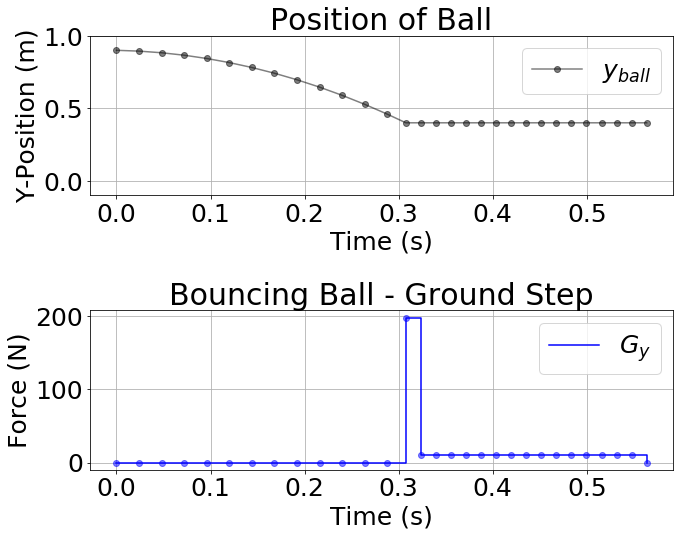

In [354]:
import matplotlib.pyplot as plt

# Plot some of the variables
GRF_ar  = [m.GRF[i,'y']() for i in range(1,N+1)]
y_ar =  [m.q[i,'y']() for i in range(1,N+1)]

tarr = [m.h[i]() for i in range (1,N+1)]
t = hm*np.cumsum(np.asarray(tarr))
t -= t[0]

nar = np.linspace(1,N,N)

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(t, y_ar, '-o', color='black',alpha=0.5, label = r'$y_{ball}$')
plt.title('Position of Ball')
plt.ylabel('Y-Position (m)')
plt.xlabel('Time (s)')
plt.legend()
plt.ylim([-0.1,1.0])
plt.grid(True)

plt.subplot(2,1,2)
plt.step(t, GRF_ar,where='post',color = 'blue', label = r'$G_{y}$')
plt.plot(t, GRF_ar, 'o', color='blue',alpha=0.5)
plt.title('Bouncing Ball - Ground Step')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.savefig('plots\\ball_ground\\ball_ground_up.svg', format='svg')


